In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as data

from model import ResidualBlock, ResNet
from train_eval_util import train, evaluate, calculate_accuracy, epoch_time
from dataset import train_data, valid_data, test_data

import time

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')  
else:
    device = torch.device('cpu')

print(f"Selected device: {device}")

Selected device: mps


In [3]:
BATCH_SIZE = 64

train_iterator = DataLoader(train_data, batch_size= BATCH_SIZE, shuffle=True)

valid_iterator =  DataLoader(valid_data, batch_size=BATCH_SIZE, shuffle=False)

test_iterator =  DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [5]:
model = ResNet(ResidualBlock, [3, 3, 3], dropout_rate=0.2).to(device)

total_layers = sum([1 for _ in model.modules() 
    if isinstance(_, nn.Conv2d) or isinstance(_, nn.Linear)]) - 2 # subtract input and output layers
    
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total number of layers: {total_layers}")
print(f"Total number of parameters: {total_params}")

from torchsummary import summary
summary(model)

Total number of layers: 20
Total number of parameters: 272474
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            432
├─BatchNorm2d: 1-2                       32
├─Sequential: 1-3                        --
|    └─ResidualBlock: 2-1                --
|    |    └─Conv2d: 3-1                  2,304
|    |    └─BatchNorm2d: 3-2             32
|    |    └─Conv2d: 3-3                  2,304
|    |    └─BatchNorm2d: 3-4             32
|    |    └─Dropout: 3-5                 --
|    |    └─Sequential: 3-6              --
|    └─ResidualBlock: 2-2                --
|    |    └─Conv2d: 3-7                  2,304
|    |    └─BatchNorm2d: 3-8             32
|    |    └─Conv2d: 3-9                  2,304
|    |    └─BatchNorm2d: 3-10            32
|    |    └─Dropout: 3-11                --
|    |    └─Sequential: 3-12             --
|    └─ResidualBlock: 2-3                --
|    |    └─Conv2d: 3-13                 2,304
|    |    └─BatchNorm2d: 3-14        

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            432
├─BatchNorm2d: 1-2                       32
├─Sequential: 1-3                        --
|    └─ResidualBlock: 2-1                --
|    |    └─Conv2d: 3-1                  2,304
|    |    └─BatchNorm2d: 3-2             32
|    |    └─Conv2d: 3-3                  2,304
|    |    └─BatchNorm2d: 3-4             32
|    |    └─Dropout: 3-5                 --
|    |    └─Sequential: 3-6              --
|    └─ResidualBlock: 2-2                --
|    |    └─Conv2d: 3-7                  2,304
|    |    └─BatchNorm2d: 3-8             32
|    |    └─Conv2d: 3-9                  2,304
|    |    └─BatchNorm2d: 3-10            32
|    |    └─Dropout: 3-11                --
|    |    └─Sequential: 3-12             --
|    └─ResidualBlock: 2-3                --
|    |    └─Conv2d: 3-13                 2,304
|    |    └─BatchNorm2d: 3-14            32
|    |    └─Conv2d: 3-15                 2,304
|    |  

In [6]:

criterion = nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.0001)

# from torch.optim.lr_scheduler import StepLR
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)



In [7]:
num_epochs = 200
train_acc_history = []
train_loss_history = []
valid_acc_history = []
valid_loss_history = []
lr_epoch = []

for epoch in range(num_epochs):

    start_time = time.time()
    
   
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    
    scheduler.step()
    lr_now = lr_now = optimizer.param_groups[0]['lr']
    lr_epoch.append(lr_now)

    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)
        
    end_time = time.time()

        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | LR: {lr_now:.6f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    

    train_acc_history.append(train_acc)
    train_loss_history.append( train_loss)
    valid_acc_history.append(valid_acc)
    valid_loss_history.append(valid_loss)

Epoch: 01 | Epoch Time: 0m 27s
	Train Loss: 1.734 | Train Acc: 34.95% | LR: 0.099994
	 Val. Loss: 1.514 |  Val. Acc: 44.44%
Epoch: 02 | Epoch Time: 0m 27s
	Train Loss: 1.356 | Train Acc: 50.04% | LR: 0.099975
	 Val. Loss: 1.145 |  Val. Acc: 58.29%
Epoch: 03 | Epoch Time: 0m 27s
	Train Loss: 1.112 | Train Acc: 60.11% | LR: 0.099944
	 Val. Loss: 0.952 |  Val. Acc: 65.51%
Epoch: 04 | Epoch Time: 0m 26s
	Train Loss: 0.964 | Train Acc: 65.98% | LR: 0.099901
	 Val. Loss: 0.878 |  Val. Acc: 69.01%
Epoch: 05 | Epoch Time: 0m 27s
	Train Loss: 0.866 | Train Acc: 69.51% | LR: 0.099846
	 Val. Loss: 0.777 |  Val. Acc: 72.77%
Epoch: 06 | Epoch Time: 0m 28s
	Train Loss: 0.786 | Train Acc: 72.42% | LR: 0.099778
	 Val. Loss: 0.832 |  Val. Acc: 72.49%
Epoch: 07 | Epoch Time: 0m 28s
	Train Loss: 0.728 | Train Acc: 74.56% | LR: 0.099698
	 Val. Loss: 0.654 |  Val. Acc: 77.45%
Epoch: 08 | Epoch Time: 0m 30s
	Train Loss: 0.684 | Train Acc: 76.13% | LR: 0.099606
	 Val. Loss: 0.627 |  Val. Acc: 78.09%
Epoch: 0

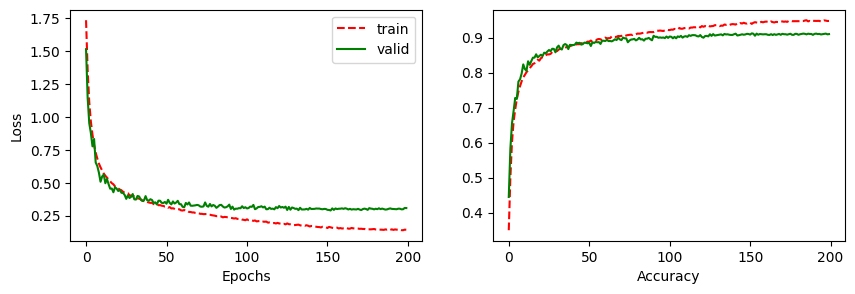

In [8]:
import matplotlib.pyplot as plt

fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(range(num_epochs), train_loss_history, '--r')
ax1.plot(range(num_epochs), valid_loss_history, '-g')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(['train', 'valid'])

ax2.plot(range(num_epochs), train_acc_history, '--r')
ax2.plot(range(num_epochs), valid_acc_history, '-g')
ax2.set_xlabel('Epochs')
ax2.set_xlabel('Accuracy')
ax1.legend(['train', 'valid'])

In [9]:
torch.save(model, 'model.pt')

In [10]:
import numpy as np 

np.save(train_acc_history, 'train_acc_history.npy')
np.save(train_loss_history, 'train_loss_history.npy')
np.save(valid_acc_history, 'valid_acc_history.npy')
np.save(valid_loss_history, 'valid_loss_history.npy')
np.save(lr_epoch, 'lr_per_epoch.npy')

TypeError: expected str, bytes or os.PathLike object, not list